In [1]:
# Install needed libraries (first time only)
!pip install -q faiss-cpu sentence-transformers nltk spacy
!python -m nltk.downloader stopwords
!python -m spacy download en_core_web_sm
!python -m nltk.downloader wordnet

import nltk
# Download NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Packag

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
from IPython.display import display
import pandas as pd
import numpy as np
import faiss
import re
import requests
from io import BytesIO
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
from nltk.stem import WordNetLemmatizer

# ------------------------- Load and Prepare Data -------------------------
# Load dataset
df = pd.read_csv("Finaldataa.csv")
df["original_description"] = df["p_name"]

# Standardize gender values strictly
gender_mapping = {
    'female': 'women', 'woman': 'women', 'women': 'women', 'womens': 'women', 'lady': 'women',
    'male': 'men', 'man': 'men', 'men': 'men', 'mens': 'men', 'gentleman': 'men',
    'girl': 'girls', 'girls': 'girls',
    'boy': 'boys', 'boys': 'boys',
    'unisex': 'unisex', 'all': 'unisex'
}
df['p_gender'] = df['p_gender'].fillna('unisex').str.lower().map(gender_mapping).fillna('unisex')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    """Enhanced text preprocessing"""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Reduce long repeated characters
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


# Preprocess descriptions and extract features
df['cleaned_description'] = df['p_name'].apply(preprocess)

# ------------------------- Enhanced Feature Extraction -------------------------
def extract_colors(text):
    """Strict color extraction"""
    colors = {
        'white', 'black', 'red', 'blue', 'green', 'yellow', 'purple', 'orange',
        'pink', 'brown', 'gray', 'grey', 'silver', 'gold', 'navy', 'beige'
    }
    text = str(text).lower()
    found = [color for color in colors if f' {color} ' in f' {text} ']  # Whole word matching
    return found[0] if found else None

df['extracted_color'] = df['cleaned_description'].apply(extract_colors)

# Initialize category classifier
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X = vectorizer.fit_transform(df['cleaned_description'])
y = df['category']
category_clf = RandomForestClassifier(n_estimators=200, random_state=42)
category_clf.fit(X, y)

# ------------------------- Initialize Models -------------------------
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings
embeddings = model.encode(df['cleaned_description'].tolist(), convert_to_numpy=True)

# Apply PCA
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(embeddings)

# Normalize embeddings
normalized_embeddings = reduced_embeddings / np.linalg.norm(reduced_embeddings, axis=1, keepdims=True)

# Create FAISS index
index = faiss.IndexFlatIP(normalized_embeddings.shape[1])
index.add(normalized_embeddings)

# Function to display images from URL
def display_image(url):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        display(img)
    except Exception as e:
        print(f"Could not display image from {url}: {e}")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

📝 Enter your fashion search query: half boot

🔍 Search Query: 'half boot'
🧍 Strict Gender: None
🎨 Color Filter: None
👕 Predicted Product Type: SHOES

⚠️ Same Category Only (10):

1. BOOT HEELS - L-106
   ⭐ Score: 0.664
   🧍 Gender: WOMEN
   🎨 Color: -
   👕 Type: shoes


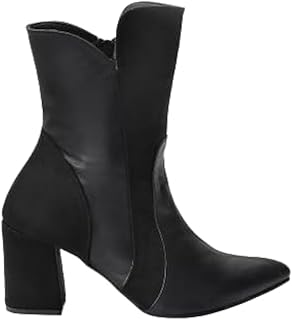


2. mens Casual Boot Fashion Boot
   ⭐ Score: 0.622
   🧍 Gender: WOMEN
   🎨 Color: -
   👕 Type: shoes


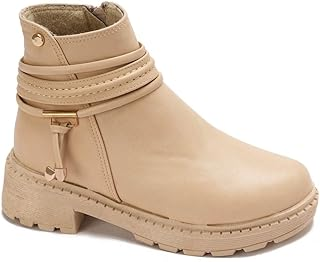


3. Glitter Women Half Boot
   ⭐ Score: 0.622
   🧍 Gender: WOMEN
   🎨 Color: -
   👕 Type: shoes


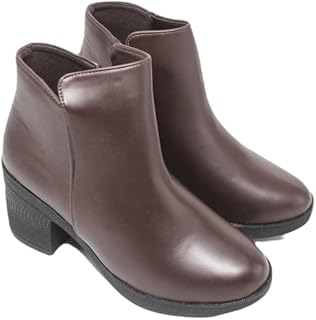


4. BOOT HEELS SUEDE -R-8
   ⭐ Score: 0.589
   🧍 Gender: WOMEN
   🎨 Color: -
   👕 Type: shoes


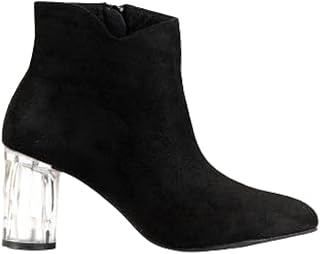


5. Stainless Steel Boots
   ⭐ Score: 0.562
   🧍 Gender: WOMEN
   🎨 Color: -
   👕 Type: shoes


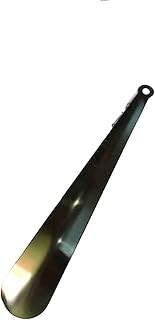


6. Woman Flat Sole Home Boots
   ⭐ Score: 0.558
   🧍 Gender: WOMEN
   🎨 Color: -
   👕 Type: shoes


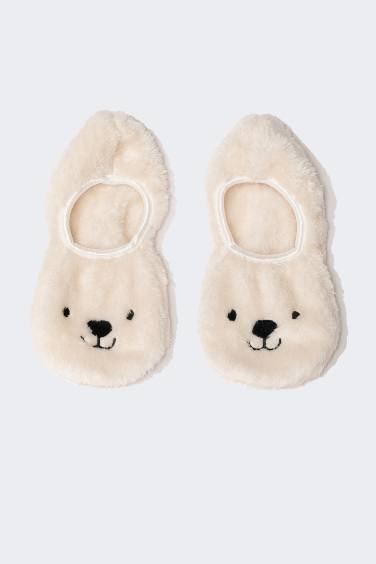


7. Woman Flat Base Home Boots
   ⭐ Score: 0.544
   🧍 Gender: WOMEN
   🎨 Color: -
   👕 Type: shoes


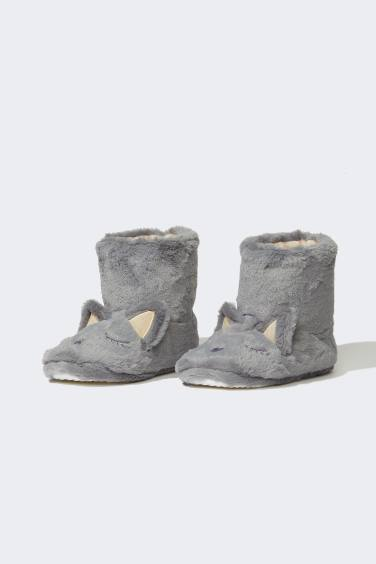


8. Woman Flat Sole Boots For House
   ⭐ Score: 0.535
   🧍 Gender: WOMEN
   🎨 Color: -
   👕 Type: shoes


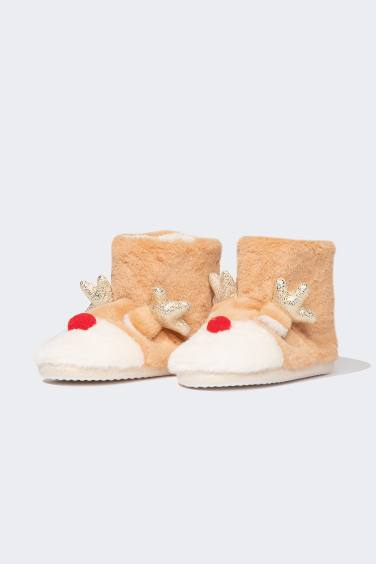


9. BOOT MID HEELS LEATHER - G-23
   ⭐ Score: 0.528
   🧍 Gender: WOMEN
   🎨 Color: -
   👕 Type: shoes


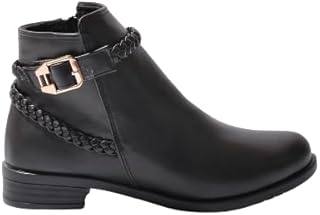


10. Glitter Women Boot
   ⭐ Score: 0.523
   🧍 Gender: WOMEN
   🎨 Color: -
   👕 Type: shoes


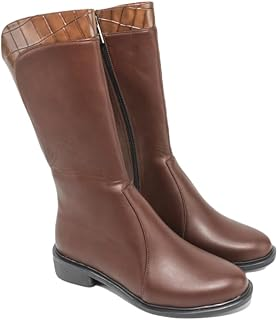

✅ Done.


In [17]:
def hybrid_search(query, total_results=10):

    """STRICT gender + category with proper exact match prioritization"""
    if not query.strip():
        print("⚠️ Query is empty. Please enter a valid search term.")
        return []

    # Preprocess query
    processed_query = preprocess(query)
    query_tokens = processed_query.split()

    # STRICT gender detection
    gender = None
    gender_keywords = {
        'women': ['women', 'woman', 'female', 'ladies', 'lady'],
        'men': ['men', 'man', 'male', 'gentlemen', 'gentleman'],
        'girls': ['girl', 'girls'],
        'boys': ['boy', 'boys']
    }

    for group, terms in gender_keywords.items():
        if any(f' {term} ' in f' {processed_query} ' for term in terms):
            gender = group
            break

    # Detect color
    color = None
    for token in query_tokens:
        if extract_colors(token):
            color = extract_colors(token)
            break

    # Predict product type using classifier
    predicted_category = category_clf.predict(vectorizer.transform([processed_query]))[0]

    print(f"\n🔍 Search Query: '{query}'")
    print(f"🧍 Strict Gender: {gender.upper() if gender else 'None'}")
    print(f"🎨 Color Filter: {color or 'None'}")
    print(f"👕 Predicted Product Type: {predicted_category.upper()}")

    # Generate query embedding
    query_vec = model.encode([processed_query], convert_to_numpy=True)
    query_vec = pca.transform(query_vec)
    query_vec = query_vec / np.linalg.norm(query_vec, axis=1, keepdims=True)

    # Get MORE initial results to find all possible matches
    D, I = index.search(query_vec, total_results*50)

    # Process results in THREE phases
    exact_matches = []
    same_gender = []
    same_category = []
    seen = set()

    for score, idx in zip(D[0], I[0]):
        if len(exact_matches) >= total_results and len(same_gender) >= total_results:
            break

        row = df.iloc[idx]

        # Skip duplicates
        if row['cleaned_description'] in seen:
            continue
        seen.add(row['cleaned_description'])

        result = {
            'score': score,
            'description': row['original_description'],
            'image': row['p_img'],
            'gender': row['p_gender'],
            'color': row['extracted_color'],
            'type': row['category'],
            'match_type': 'similar'
        }

        # Phase 1: Exact matches (all filters)
        if gender and predicted_category:
            gender_match = (row['p_gender'] == gender) or (row['p_gender'] == 'unisex')
            type_match = (predicted_category.lower() in row['category'].lower())
            color_match = (not color) or (row['extracted_color'] == color)

            if gender_match and type_match and color_match:
                result['match_type'] = 'exact'
                exact_matches.append(result)
                continue

        # Phase 2: Same predicted category (relax gender and color)
        if predicted_category.lower() in row['category'].lower():
            if gender:
                if (row['p_gender'] == gender) or (row['p_gender'] == 'unisex'):
                    same_gender.append(result)
            else:
                same_category.append(result)

    # Build final results - STRICT priority
    final_results = []

    # 1. Add ALL exact matches first
    final_results.extend(exact_matches)

    # 2. Fill with same-gender matches if gender was specified
    if gender:
        remaining = total_results - len(final_results)
        final_results.extend(same_gender[:remaining])

    # 3. Use same-category matches
    remaining = total_results - len(final_results)
    final_results.extend(same_category[:remaining])

    # Display results
    exact_count = sum(1 for r in final_results if r['match_type'] == 'exact')
    same_gender_count = sum(1 for r in final_results if r['match_type'] == 'similar' and gender)

    if exact_count > 0:
        print(f"\n🎯 Exact Matches ({exact_count}):")
        for i, res in enumerate(final_results[:exact_count], 1):
            print(f"\n{i}. {res['description']}")
            print(f"   ⭐ Score: {res['score']:.3f}")
            print(f"   🧍 Gender: {res['gender'].upper()}")
            print(f"   🎨 Color: {res['color'] or '-'}")
            print(f"   👕 Type: {res['type'] or '-'}")
            display_image(res['image'])

    if same_gender_count > 0:
        start = exact_count
        end = exact_count + same_gender_count
        print(f"\n💡 Same Gender/Category ({same_gender_count}):")
        for i, res in enumerate(final_results[start:end], start+1):
            print(f"\n{i}. {res['description']}")
            print(f"   ⭐ Score: {res['score']:.3f}")
            print(f"   🧍 Gender: {res['gender'].upper()}")
            print(f"   🎨 Color: {res['color'] or '-'}")
            print(f"   👕 Type: {res['type'] or '-'}")
            display_image(res['image'])

    if len(final_results) > (exact_count + same_gender_count):
        start = exact_count + same_gender_count
        print(f"\n⚠️ Same Category Only ({len(final_results)-start}):")
        for i, res in enumerate(final_results[start:], start+1):
            print(f"\n{i}. {res['description']}")
            print(f"   ⭐ Score: {res['score']:.3f}")
            print(f"   🧍 Gender: {res['gender'].upper()}")
            print(f"   🎨 Color: {res['color'] or '-'}")
            print(f"   👕 Type: {res['type'] or '-'}")
            display_image(res['image'])

    return final_results

# Ask user for input
user_query = input("📝 Enter your fashion search query: ")
results = hybrid_search(user_query)
print("✅ Done.")
